In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
#elec_data_all = pd.read_csv('election_data_clean.csv',index_col=0)
#elec_data = elec_data_all[elec_data_all['County Code'].isin(['SEM','VOL'])]
elec_data= pd.read_csv('election_data_clean.csv',index_col=0)

C:\Users\spear_000\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3050: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
elections = elec_data.groupby("Contest Name")

In [4]:
state_house = elections.get_group('State Representative')
house_gb = state_house.groupby("District")

In [5]:
def sh_analyze(District):
    missing_data = []
    sh_n = house_gb.get_group(f" District {District}")
    gb_n = sh_n.groupby('Precinct Number')
    gb_n_keys = gb_n.groups.keys()
    my_data = {'Precinct Number':[],
               'Registered Republican %':[],
               'Registered Democrat %':[],
               'Registered Other %':[],
               'Total Registered':[],
               'Dem Vote %':[],
               'Repub Vote %':[],
               'Total_Votes':[]}
    for precinct in gb_n_keys:
        data = gb_n.get_group(precinct)
        total_registered = float(data['Total Registered'].tolist()[0])
        try:
            dems=float(data[data['Party']=='DEM']["Vote Total"].tolist()[0])
        except IndexError:
            dems=0
        try:
            repubs=float(data[data['Party']=='REP']["Vote Total"].tolist()[0])
        except IndexError:
            repubs=0
        if total_registered > 0 and dems+repubs>0:
            my_data['Precinct Number'].append(precinct)
            my_data['Registered Republican %'].append(100*float(data['Registered Republicans'].tolist()[0])/total_registered)
            my_data['Registered Democrat %'].append(100*float(data['Registered Democrats'].tolist()[0])/total_registered)
            my_data['Registered Other %'].append(100*float(data['Registered Other'].tolist()[0])/total_registered)
            my_data['Total Registered'].append(total_registered)
            total = dems+repubs
            my_data['Dem Vote %'].append(100*dems/total)
            my_data['Repub Vote %'].append(100*repubs/total)
            my_data['Total_Votes'].append(total)
        elif total_registered == 0:
            missing_data.append(f"Precinct {precinct} has no registered voters")
        elif dems+repubs == 0:
            missing_data.append(f"Precinct {precinct} has no major party votes")
    df = pd.DataFrame(my_data,index=my_data["Precinct Number"])
    df['Turnout']=100*df['Total_Votes']/df['Total Registered']
    
    #We remove precincts with lower than 4 percent turnout as these are typically precincts not in the district
    df = df[df['Turnout']>=4]
    return [df,missing_data]

In [10]:
def turnout_scatter(District):
    df = sh_analyze(District)[0]
    plt.scatter(df['Registered Democrat %'],df['Turnout'])
    plt.xlabel("Percent of Voters Registered as Democrats")
    plt.ylabel("Voter Turnout (Percent)")
    plt.title(f"Voter Turnout vs. Party by Precincts in House District {District}")
    plt.savefig(f"state_house_district_{District}_turnout")
    plt.show()
    print(linregress(df['Registered Democrat %'],df['Turnout']))
   

In [7]:
def proportional_vote(District):
    district_sh_df = sh_analyze(District)[0]
    dem_hyp = (district_sh_df['Dem Vote %']/100*district_sh_df['Total Registered']).sum()
    repub_hyp = (district_sh_df['Repub Vote %']/100*district_sh_df['Total Registered']).sum()
    return round(dem_hyp/(dem_hyp+repub_hyp)*100,4)

def actual_vote(District):
    district_sh_df = sh_analyze(District)[0]
    dem_act = (district_sh_df['Dem Vote %']/100*district_sh_df['Total_Votes']).sum()
    repub_act = (district_sh_df['Repub Vote %']/100*district_sh_df['Total_Votes']).sum()
    return round(dem_act/(dem_act+repub_act)*100,4)

In [8]:
house_gb.groups.keys()

dict_keys([' District 1', ' District 10', ' District 103', ' District 105', ' District 106', ' District 108', ' District 11', ' District 111', ' District 112', ' District 113', ' District 114', ' District 115', ' District 116', ' District 118', ' District 119', ' District 12', ' District 120', ' District 15', ' District 16', ' District 17', ' District 19', ' District 21', ' District 22', ' District 23', ' District 24', ' District 25', ' District 26', ' District 27', ' District 28', ' District 29', ' District 3', ' District 30', ' District 31', ' District 32', ' District 33', ' District 34', ' District 35', ' District 36', ' District 37', ' District 38', ' District 39', ' District 4', ' District 40', ' District 42', ' District 44', ' District 47', ' District 48', ' District 49', ' District 50', ' District 51', ' District 52', ' District 53', ' District 54', ' District 55', ' District 56', ' District 57', ' District 58', ' District 59', ' District 6', ' District 60', ' District 61', ' Di

In [9]:
for n in range(1,121):
    try:
        print((f"In district {n}, democrats got {actual_vote(n)}% of the vote. "+
               f"Had precincts voted proportionally, they would have gotten {proportional_vote(n)}%"))
    except KeyError:
        print(f"KeyError District {n}")
    except IndexError:
        print(f"IndexError District {n}")

In district 1, democrats got 39.2184% of the vote. Had precincts voted proportionally, they would have gotten 39.8744%
KeyError District 2
In district 3, democrats got 0.0% of the vote. Had precincts voted proportionally, they would have gotten 0.0%
In district 4, democrats got 27.8709% of the vote. Had precincts voted proportionally, they would have gotten 28.4708%
KeyError District 5
In district 6, democrats got 0.0% of the vote. Had precincts voted proportionally, they would have gotten 0.0%
KeyError District 7
KeyError District 8
KeyError District 9
In district 10, democrats got 24.7237% of the vote. Had precincts voted proportionally, they would have gotten 25.5509%
In district 11, democrats got 30.2657% of the vote. Had precincts voted proportionally, they would have gotten 30.3695%
In district 12, democrats got 40.7737% of the vote. Had precincts voted proportionally, they would have gotten 41.373%
KeyError District 13
KeyError District 14
In district 15, democrats got 49.0878% 

In district 85, democrats got 45.388% of the vote. Had precincts voted proportionally, they would have gotten 45.8756%
In district 86, democrats got 59.824% of the vote. Had precincts voted proportionally, they would have gotten 60.495%
In district 87, democrats got 100.0% of the vote. Had precincts voted proportionally, they would have gotten 100.0%
KeyError District 88
In district 89, democrats got 49.9796% of the vote. Had precincts voted proportionally, they would have gotten 50.6843%
KeyError District 90
KeyError District 91
KeyError District 92
In district 93, democrats got 46.3959% of the vote. Had precincts voted proportionally, they would have gotten 46.8922%
KeyError District 94
KeyError District 95
KeyError District 96
KeyError District 97
In district 98, democrats got 64.043% of the vote. Had precincts voted proportionally, they would have gotten 64.3779%
KeyError District 99
KeyError District 100
KeyError District 101
KeyError District 102
In district 103, democrats got 53

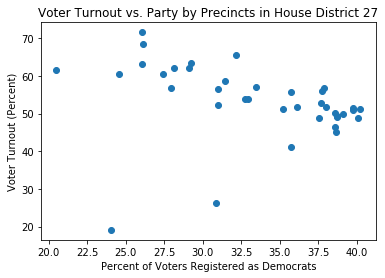

LinregressResult(slope=-0.524355545354532, intercept=70.99168001685511, rvalue=-0.2904839446173127, pvalue=0.07685755349173003, stderr=0.28787894205660586)


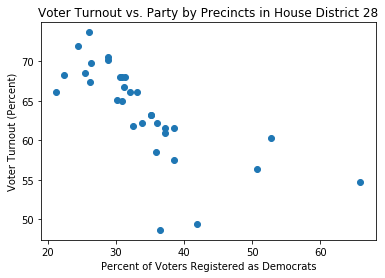

LinregressResult(slope=-0.4608021100471281, intercept=79.44822484557109, rvalue=-0.7013939176808254, pvalue=7.749315218068044e-06, stderr=0.08549556742783053)


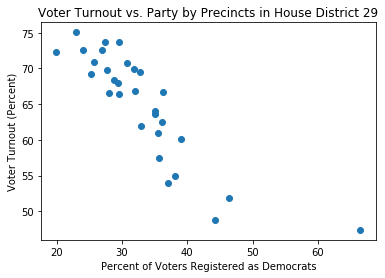

LinregressResult(slope=-0.7546920652096368, intercept=89.92967074982309, rvalue=-0.8633274240704901, pvalue=8.261795856314426e-10, stderr=0.08336821623171317)


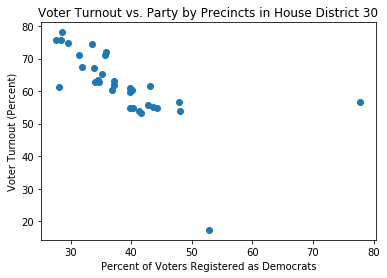

LinregressResult(slope=-0.7103156313910058, intercept=89.2498236707009, rvalue=-0.6072970404540003, pvalue=0.00017846974253604153, stderr=0.16689738037463622)


In [13]:
for i in range(27,31):
    turnout_scatter(i)